# Package LAB

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import LL_RT, PID_RT, IMCTuning, Controller
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

# LL_RT()

In [24]:
help(LL_RT)

Help on function LL_RT in module package_LAB:

LL_RT(MV, Kp, Tlead, Tlag, Ts, PV, PVInit=0, method='EBD')
    The function "LL_T" needs to be included in a "for or while loop".

    :MV: input vector
    :Kp: process gain
    :Tlead: lead time constant [s]
    :Tlag: lag time constant [s]
    :Ts: sampling period [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretization method (optional: default value is 'EBD')
        EBD: Euler Backward difference
        EFD: Euler Forward difference

    The function "LEADLAG_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretization method.



(0.0, 100.0)

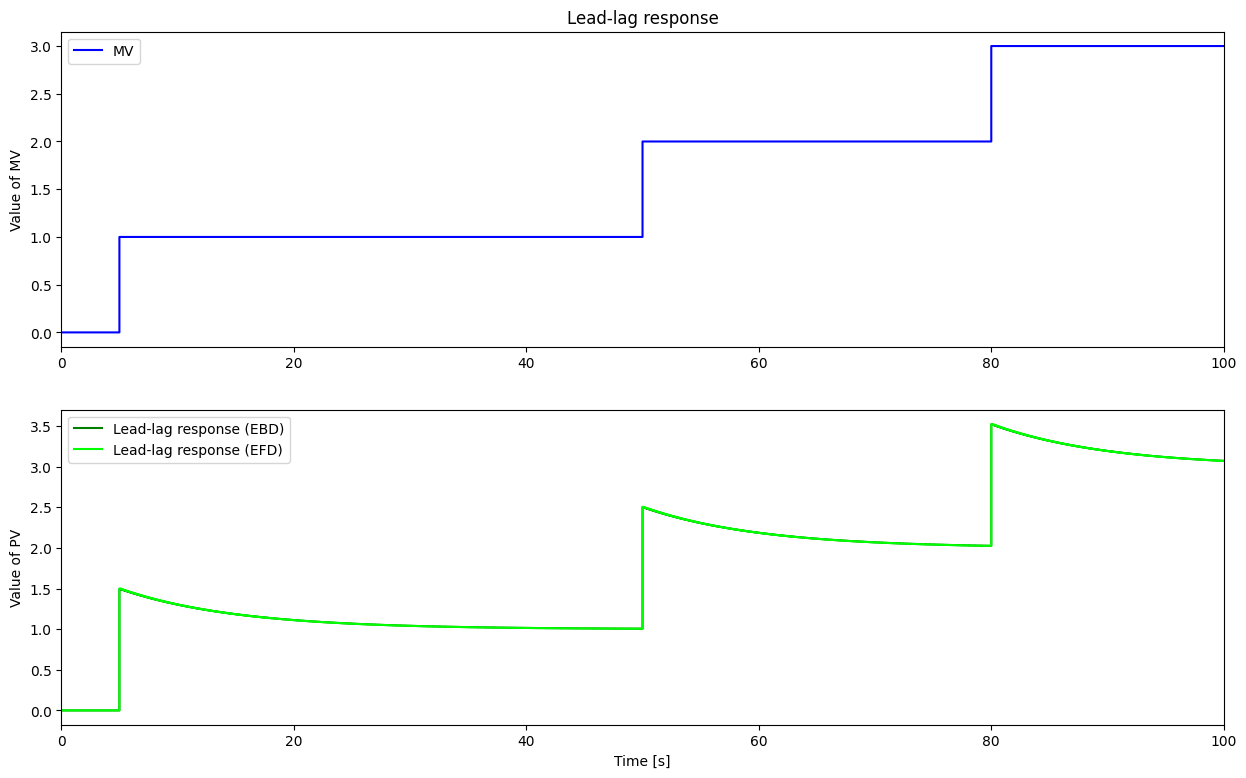

In [25]:
TSim = 100
Ts = 0.1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 0, 5: 1, 50: 2, 80: 3, TSim: 3}

t = []
MV = []
PV_EBD = []
PV_EFD = []


# Parameters
Kp = 1
Tlead = 15
Tlag = 10
theta = 10

for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)
    LL_RT(MV,Kp,Tlead,Tlag,Ts,PV_EBD)
    LL_RT(MV,Kp,Tlead,Tlag,Ts,PV_EFD,0,'EFD')
    
plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('Lead-lag response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(2,1,2)
plt.step(t,PV_EBD,'g-',label='Lead-lag response (EBD)',where='post')
plt.step(t,PV_EFD,'lime',label='Lead-lag response (EFD)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

# PID_RT()

In [26]:
help(PID_RT)

Help on function PID_RT in module package_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=0, method='EBD-EBD')
    The function "PID_RT" needs to be included in a "for or while loop".

    :SP: SP (or SetPoint) vector
    :PV: PV (or Process Value) vector
    :Man: Man (or Manual controller mode) vector (True or False)
    :MVMan: MVMan (or Manual value for MV) vector
    :MVFF: MVFF (or Feedforward) vector

    :Kc: controller gain
    :Ti: integral time constant [s]
    :Td: derivative time constant [s]
    :alpha: Tfd = alpha*Td where Tfd is the derivative filter time constant [s]
    :Ts: sampling period [s]

    :MVMin: minimum value for MV (used for saturation and anti wind-up)
    :MVMax: maximum value for MV (used for saturation and anti wind-up)

    :MV: MV (or Manipulated Value) vector
    :MVP: MVP (or Proportional part of MV) vector
    :MVI: MVI (or Integral part of MV) vector
    :MVD: MVD (or Derivati

(0.0, 200.0)

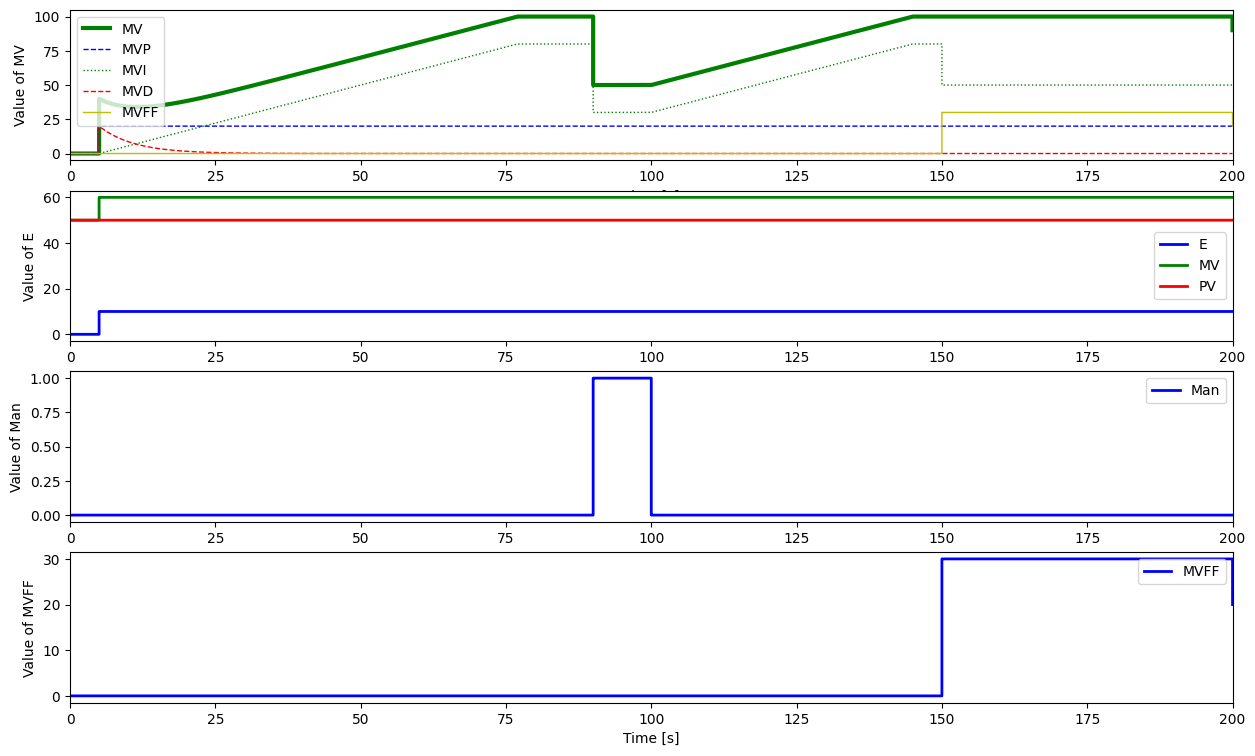

In [37]:
TSim = 200
Ts = 0.01
N = int(TSim/Ts) + 1

# Path for MV
SPPath = {0: 50, 5: 60, TSim: 60}
PVPath = {0: 50, 5: 50, TSim: 50}
ManPath = {0: False, 90: True, 100: False, TSim: False}
MVManPath = {0: 50, TSim: 50}
MVFFPath = {0: 0, 150: 30, TSim: 20}

t = []
SP = []
PV = []
MV = []
MVP = []
MVI = []
MVD = []
E = []
Man = []
MVMan = []
MVFF = []

# Parameters
Kc = 2
Ti = 18
Td = 6
alpha = 0.3
MVMin = 0
MVMax = 100

for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(PVPath,t,PV)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    SelectPath_RT(MVFFPath,t,MVFF)
    PID_RT(SP,PV,Man,MVMan,MVFF, Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E)
    
plt.figure(figsize = (15,9))

plt.subplot(4,1,1)
plt.step(t,MV,'g-',linewidth=3, label='MV',where='post')
plt.step(t,MVP,'b--',linewidth=1, label='MVP',where='post')
plt.step(t,MVI,'g:',linewidth=1, label='MVI',where='post')
plt.step(t,MVD,'r--',linewidth=1, label='MVD',where='post')
plt.step(t,MVFF,'y-',linewidth=1, label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,E,'b-',linewidth=2, label='E',where='post')
plt.step(t,SP,'g-',linewidth=2, label='MV',where='post')
plt.step(t,PV,'r-',linewidth=2, label='PV',where='post')
plt.ylabel('Value of E')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])  

plt.subplot(4,1,3)
plt.step(t,Man,'b-',linewidth=2, label='Man',where='post')
plt.ylabel('Value of Man')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,4)
plt.step(t,MVFF,'b-',linewidth=2, label='MVFF',where='post')
plt.ylabel('Value of MVFF')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim]) 

# IMC Tuning

In [28]:
help(IMCTuning)

Help on function IMCTuning in module package_LAB:

IMCTuning(k, Tlag1, Tlag2=0, theta=0, gamma=0.5, process='SOPDT')
    IMCTuning(K, Tlag1, Tlag2=0, theta=0, gamma=0.5, process='SOPDT')

    The function "IMCTuning" computes the IMC PID tuning parameters for SOPDT processes.
    For a SOPDT process we impleent the line I of the IMC tuning table (with T3=0)

    :K: process gain
    :Tlag1: first (or main) lag time constant [s]
    :Tlag2: second lag time constant [s]
    :theta: process delay
    :gamma: loop response time as a ratio of T1



In [30]:
Kp_SOPDTOPT= 0.4306576253666714
T1_SOPDTOPT= 238.7362471589338
T2_SOPDTOPT= 15.201603494821217
Theta_SOPDTOPT= 3.1282416191455016

gamma = 0.6
Kc, Ti, Td = IMCTuning(Kp_SOPDTOPT,T1_SOPDTOPT,T2_SOPDTOPT,Theta_SOPDTOPT,gamma,'SOPDT')

print('Kc = ', Kc)
print('Ti = ', Ti)
print('Td = ', Td)

Kc =  4.028498952772296
Ti =  253.93785065375502
Td =  14.291582604989983
